# COMP578 Data Mining Spring 2017
## Assignment 10

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.cross_decomposition
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.decomposition
import sklearn.cluster
import scipy.cluster

from mpl_toolkits.mplot3d import Axes3D

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [3]:
def get_labels(file):
    labels = []
    for i, line in enumerate(file):
        labels.append(line.strip().split(','))  
    return np.array(labels)

def get_curves(dir, shape):
    labels = get_labels(open(os.path.join(dir, "labels.txt")))
    curves = np.empty(shape)
    for i, curve_label in enumerate(labels[:, 0]):
        curves[i] = np.genfromtxt(os.path.join(dir, curve_label + ".dat"))

    np.place(curves, curves==0, [curves.max()]) # eliminate zeros (NaN in LIDAR jargon)
    curves = curves.astype(int)

    return curves, labels

curves, labels = get_curves('Data', (9,17))


lidar = pd.DataFrame(data=curves)
lidar = lidar.transpose()
lidar.columns = labels[:,0]
lidar


,lt,rt,ts,xs,tl,tr,dr,dl,d2
0,100,100,100,100,100,100,100,100,100
1,110,110,110,110,110,110,110,110,110
2,120,120,120,120,120,120,120,120,120
3,130,130,130,130,130,130,130,130,130
4,148,148,148,148,148,148,148,148,148
5,180,180,180,180,180,180,180,180,180
6,240,885,885,885,240,885,465,240,465
7,460,820,820,820,460,820,515,460,515
8,800,800,800,1350,1350,1350,800,1350,1350
9,815,815,815,1350,1350,1350,815,1350,1350


### Task 1
##### 10 points

Using the LIDAR data set generate 1000 distorted points using bagging with repetitions. That is, select the data for a particular cue with a uniform distribution, and then apply the Gaussian distortion and save the new data point into the data set. Use $\mu=0.0$ and $\sigma=0.1$ in this task. Split the set into a training and testing parts.

Perform PCR on the train part of the data set and plot the MSE as a function of the number of principal components in regression.

Select the best performing number of principal components and then test the performance of the model on the test part of the data set.

<b><i> In this data set, the LIDAR data represents 9 possible classifications, with 17 components to each. I have chosen to work with a single classification (left turn), as the methods in these tasks are regressive in nature. In this way we can see how many (and perhaps which) components are absolutely necessary to identify a particular classification.</i></b>

In [4]:
def get_distorted_curve(curve, sigma=0.1, mu=0.0):
  l = len(curve)
  return curve * (1 + np.random.normal(mu, sigma, l))

        0        1        2        3        4        5        6        7   \
0  102.907  86.2245  144.645  140.235  152.448  156.725  248.927  552.035   
1  107.579  110.526  117.498  174.351  156.306  172.682  230.994  534.974   
2  106.247  109.372  115.794   127.05  154.616  180.204  226.259  441.083   
3  105.524  116.647  136.559  133.537  137.082  205.592  213.032  428.998   
4  99.9712  95.3246  113.093  132.859  129.258   146.71  249.758  488.605   

        8        9        10       11       12       13       14       15  \
0  806.951   707.24   1027.5  967.176  1319.41  1344.82  1389.19  537.709   
1  721.821  747.549  784.372  1074.69  1067.16  1430.94  1369.84  489.275   
2  793.227  754.242  753.225  1119.72  1121.64  1137.69  1532.49  450.504   
3  702.981  828.313  916.042  965.166  1154.47  1408.29   1409.5  488.095   
4  734.862   715.31  805.891  731.093  1053.68  1119.22  1241.24  539.907   

        16  
0  501.621  
1  465.171  
2  463.921  
3   404.34  
4   467.7

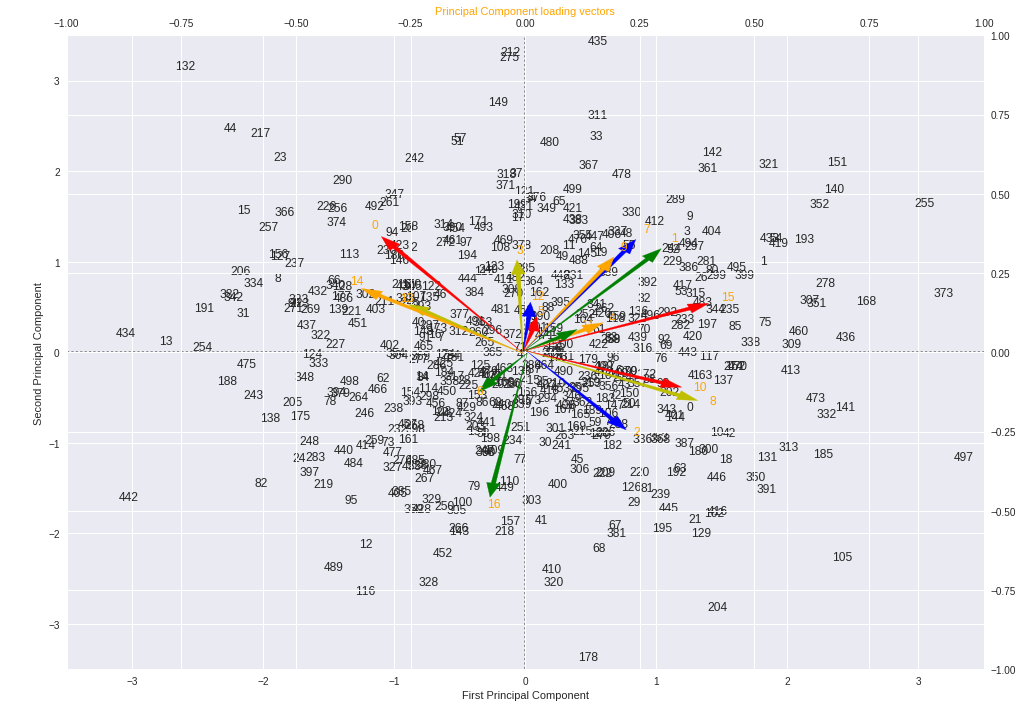

In [5]:
#create dataframe that holds 1000 distorted data points FOR A SINGLE CUE
lidar_gaus = pd.DataFrame(index = np.arange(1000),columns=lidar.index)

for x in range (0,1000):
    lidar_gaus.iloc[x] = get_distorted_curve(curves[0]) #distorted curves for left turn (lt)
print(lidar_gaus.head(5))

lidar_gaus_train, lidar_gaus_test = sklearn.model_selection.train_test_split(lidar_gaus,train_size = 0.5, random_state=2)

X = pd.DataFrame(sklearn.preprocessing.scale(lidar_gaus_train), columns=lidar_gaus_train.columns)
# The loading vectors
pca_loadings = pd.DataFrame(sklearn.decomposition.PCA().fit(X).components_.T, index=lidar_gaus_train.columns, columns=['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15','V16','V17'])

# Fit the PCA model and transform X to get the principal components
pca = sklearn.decomposition.PCA()
df_plot = pd.DataFrame(pca.fit_transform(X),index=X.index,columns=['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10','P11','P12','P13','P14','P15','P16','P17'])

fig , ax1 = plt.subplots(figsize=(14,10))

ax1.set_xlim(-3.5,3.5)
ax1.set_ylim(-3.5,3.5)

# Plot Principal Components 1 and 2
for i in df_plot.index:
    ax1.annotate(i, (-df_plot['P1'].loc[i], -df_plot['P2'].loc[i]), ha='center')

# Plot reference lines
ax1.hlines(0,-3.5,3.5, linestyles='dotted', colors='grey')
ax1.vlines(0,-3.5,3.5, linestyles='dotted', colors='grey')

ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
    
# Plot Principal Component loading vectors, using a second y-axis.
ax2 = ax1.twinx().twiny() 

ax2.set_ylim(-1,1)
ax2.set_xlim(-1,1)
ax2.tick_params(axis='y', colors='orange')
ax2.set_xlabel('Principal Component loading vectors', color='orange')

# Plot labels for vectors. Variable 'a' is a small offset parameter to separate arrow tip and text.
a = 1.07  
for i in pca_loadings[[0,1]].index:
    ax2.annotate(i, (-pca_loadings.V1.loc[i]*a, -pca_loadings.V2.loc[i]*a), color='orange')

# Plot vectors
ax2.arrow(0,0,-pca_loadings.V1[0], -pca_loadings.V2[0], ec='r', fc='r', length_includes_head=True, width=0.01)
ax2.arrow(0,0,-pca_loadings.V1[1], -pca_loadings.V2[1], ec='g', fc='g', length_includes_head=True, width=0.01)
ax2.arrow(0,0,-pca_loadings.V1[2], -pca_loadings.V2[2], ec='b', fc='b', length_includes_head=True, width=0.01)
ax2.arrow(0,0,-pca_loadings.V1[3], -pca_loadings.V2[3], ec='y', fc='y', length_includes_head=True, width=0.01)
ax2.arrow(0,0,-pca_loadings.V1[4], -pca_loadings.V2[4], ec='orange', fc='orange', length_includes_head=True, width=0.01)
ax2.arrow(0,0,-pca_loadings.V1[5], -pca_loadings.V2[5], ec='r', fc='r', length_includes_head=True, width=0.01)
ax2.arrow(0,0,-pca_loadings.V1[6], -pca_loadings.V2[6], ec='g', fc='g', length_includes_head=True, width=0.01)
ax2.arrow(0,0,-pca_loadings.V1[7], -pca_loadings.V2[7], ec='b', fc='b', length_includes_head=True, width=0.01)
ax2.arrow(0,0,-pca_loadings.V1[8], -pca_loadings.V2[8], ec='y', fc='y', length_includes_head=True, width=0.01)
ax2.arrow(0,0,-pca_loadings.V1[9], -pca_loadings.V2[9], ec='orange', fc='orange', length_includes_head=True, width=0.01)
ax2.arrow(0,0,-pca_loadings.V1[10], -pca_loadings.V2[10], ec='r', fc='r', length_includes_head=True, width=0.01)
ax2.arrow(0,0,-pca_loadings.V1[11], -pca_loadings.V2[11], ec='g', fc='g', length_includes_head=True, width=0.01)
ax2.arrow(0,0,-pca_loadings.V1[12], -pca_loadings.V2[12], ec='b', fc='b', length_includes_head=True, width=0.01)
ax2.arrow(0,0,-pca_loadings.V1[13], -pca_loadings.V2[13], ec='y', fc='y', length_includes_head=True, width=0.01)
ax2.arrow(0,0,-pca_loadings.V1[14], -pca_loadings.V2[14], ec='orange', fc='orange', length_includes_head=True, width=0.01)
ax2.arrow(0,0,-pca_loadings.V1[15], -pca_loadings.V2[15], ec='r', fc='r', length_includes_head=True, width=0.01)
ax2.arrow(0,0,-pca_loadings.V1[16], -pca_loadings.V2[16], ec='g', fc='g', length_includes_head=True, width=0.01)

fig.tight_layout()
plt.show()



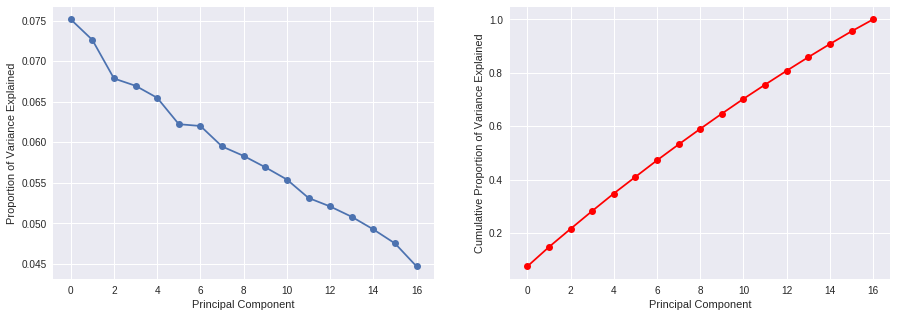

In [6]:
fig , (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

# Left plot
ax1.plot(pca.explained_variance_ratio_, '-o')
ax1.set_ylabel('Proportion of Variance Explained')
#ax1.set_ylim(ymin=-0.01)

# Right plot
ax2.plot(np.cumsum(pca.explained_variance_ratio_), '-ro')
ax2.set_ylabel('Cumulative Proportion of Variance Explained')
#ax2.set_ylim(ymax=1.05)

for ax in fig.axes:
    ax.set_xlabel('Principal Component')
    #ax.set_xlim(-1,65)  
    
plt.show()

In [7]:
def plot_mse(mse):
    fig , ax = plt.subplots(figsize=(12,7))

    ax.plot(mse, '-v')
    ax.set_xlabel('Number of principal components in regression')
    ax.set_ylabel('MSE')
    ax.set_xticks(np.arange(-1, 18, 1))
    plt.show()
    
def pcr(X, y):
    # NOTE: we repeat the pca here for completeness of the function
    pca = sklearn.decomposition.PCA()
    X_reduced = pca.fit_transform(sklearn.preprocessing.scale(X))
    n = len(X_reduced)

    # 10-fold CV, with shuffle
    kf_10 = sklearn.model_selection.KFold(n_splits=10, shuffle=False, random_state=1)

    regr = sklearn.linear_model.LinearRegression()
    mse = []

    # Calculate MSE with only the intercept (no principal components in regression)
    score = -1*sklearn.model_selection.cross_val_score(regr, np.ones((n,1)), y, cv=kf_10, scoring='neg_mean_squared_error').mean()    
    mse.append(score)

    # Calculate MSE using CV for the 17 principle components, adding one component at the time.
    for i in np.arange(1, 17):
        score = -1*sklearn.model_selection.cross_val_score(regr, X_reduced[:,:i], y, cv=kf_10, scoring='neg_mean_squared_error').mean()
        mse.append(score)
    
    return pca, X_reduced, mse

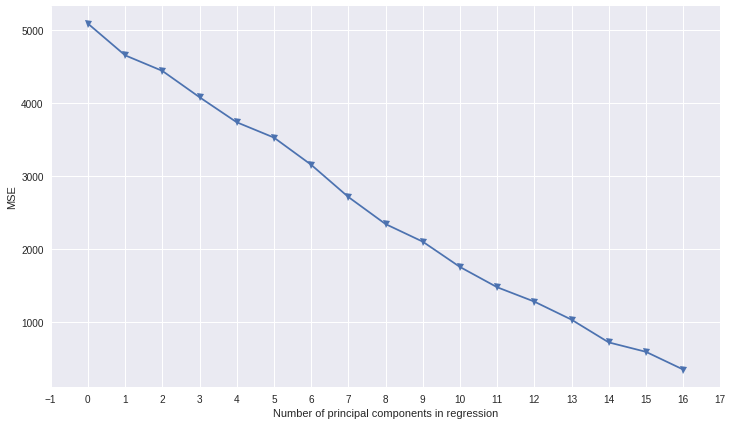

In [8]:
pca, X_reduced, mse = pcr(X, lidar_gaus_train)

plot_mse(mse)

The best performing number of principal components is 17.

In [9]:
pca.fit(lidar_gaus_train)
pca.score(lidar_gaus_test)

-86.838479409322332

### Task 2
##### 10 points

Using the same data set, perform PLS on the data set and plot the MSE as a function of the number of principal components in regression. Test the prformance of the best model (the one with the lowest MSE) on the test data set.
> This is same procedure as in Task 1 but with PLS rather than PCR.

In [10]:
lidar_gaus = pd.DataFrame(index = np.arange(1000),columns=lidar.index)

regr = sklearn.linear_model.LinearRegression()

for x in range (0,1000):
    lidar_gaus.iloc[x] = get_distorted_curve(curves[0]) #distorted curves for left turn (lt)

lidar_gaus_train, lidar_gaus_test = sklearn.model_selection.train_test_split(lidar_gaus,train_size = 0.5, random_state=2)

X = pd.DataFrame(sklearn.preprocessing.scale(lidar_gaus_train), columns=lidar_gaus_train.columns)

regr.fit(lidar_gaus_train,X)
regr.score(lidar_gaus_test,X)

-1.0004818030247855

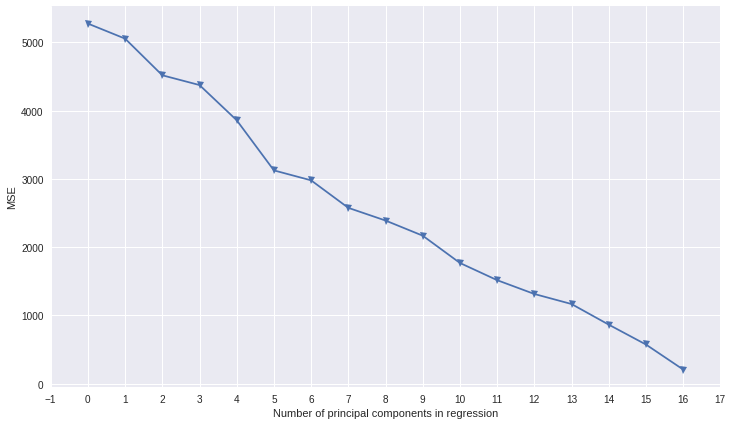

In [11]:
pca, X_reduced, mse = pcr(X, lidar_gaus_train)

plot_mse(mse)

### Task 3
##### 5 points

Perform PCA on the data set again (or reuse what you obtained earlier as part of the PCR).

Illustrate how the data is morphed into the new dimension spanned by the three first principal components using a 3D scatter plot.
> Follow the way 2D graphs were built in the lab for PC1 vs. PC2, and for PC1 vs. PC2 applied to the `Hitters` data set. Instead of using two graphs for two principal components each, use one 3D graph to show the data morphed by applying the three first principal components.

        0        1        2        3        4        5        6        7   \
0  100.256  100.656   121.88  136.314  149.937  158.342  259.533  457.145   
1  116.936  114.487  134.277  143.239  147.592  182.761  242.354  511.464   
2  85.7716  118.528  113.962  121.727  147.076   217.47   239.76  564.284   
3  94.3865  106.611  131.576   123.49  153.612  210.092  226.878  531.513   
4  85.9662  103.371  123.533   133.91    186.6  186.695  207.766  500.584   

        8        9        10       11       12       13       14       15  \
0  840.647  651.421  674.531   813.85  1028.48  1435.61  1285.34  489.452   
1  721.679  881.809  760.384  1132.73  1030.88  1206.45  1297.53  560.205   
2   762.94  650.625  844.742  1070.92  947.213  1244.45  1530.95  554.679   
3  693.496  980.068  892.057  986.703  1229.93  1158.26  1308.53  563.586   
4  719.912  846.372  837.499  772.181   994.96  1428.89  1474.66  581.817   

        16  
0  548.455  
1  454.473  
2  569.166  
3  443.747  
4  475.69

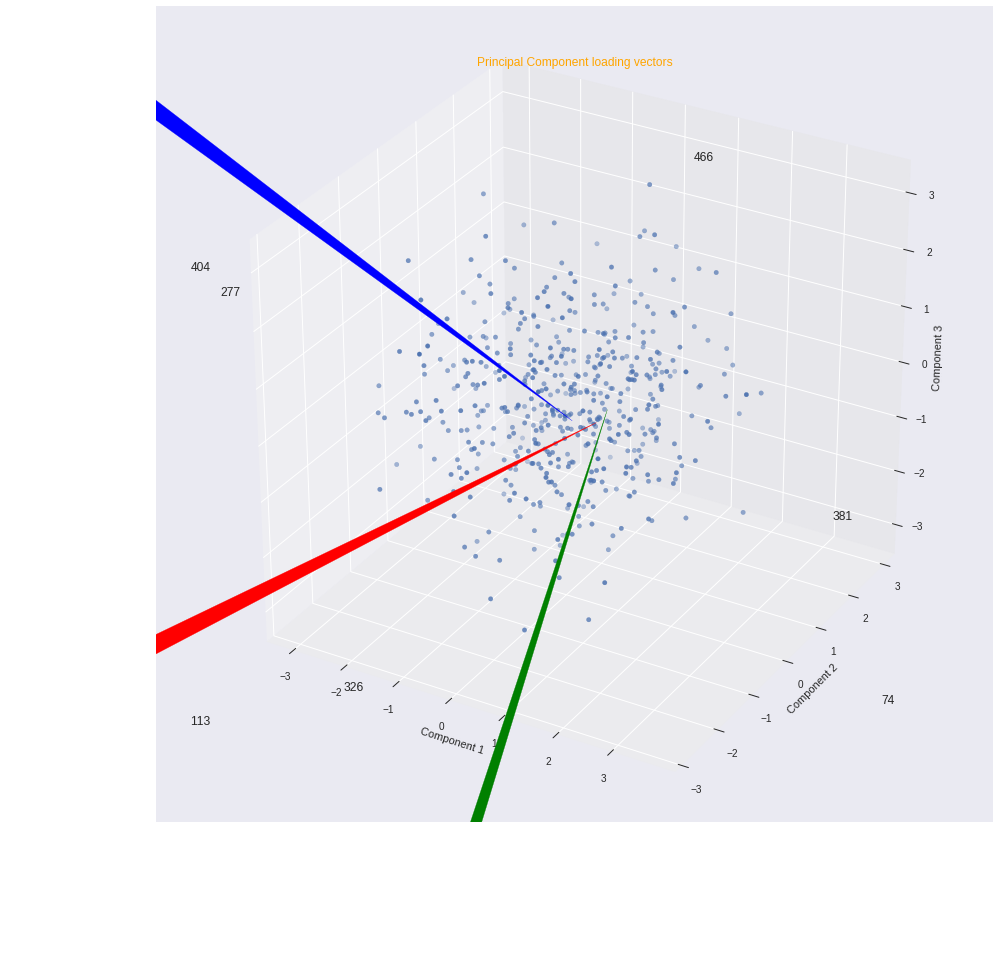

In [12]:
#create dataframe that holds 1000 distorted data points FOR A SINGLE CUE
lidar_gaus = pd.DataFrame(index = np.arange(1000),columns=lidar.index)

for x in range (0,1000):
    lidar_gaus.iloc[x] = get_distorted_curve(curves[0]) #distorted curves for left turn (lt)
print(lidar_gaus.head(5))

lidar_gaus_train, lidar_gaus_test = sklearn.model_selection.train_test_split(lidar_gaus,train_size = 0.5, random_state=2)

X = pd.DataFrame(sklearn.preprocessing.scale(lidar_gaus_train), columns=lidar_gaus_train.columns)
# The loading vectors
pca_loadings = pd.DataFrame(sklearn.decomposition.PCA().fit(X).components_.T, index=lidar_gaus_train.columns, columns=['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15','V16','V17'])

# Fit the PCA model and transform X to get the principal components
pca = sklearn.decomposition.PCA()
df_plot = pd.DataFrame(pca.fit_transform(X),index=X.index,columns=['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10','P11','P12','P13','P14','P15','P16','P17'])

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111,projection='3d')
x = df_plot['P1']
y = df_plot['P2']
z = df_plot['P3']

for i in df_plot.index:
    ax.annotate(i, (-df_plot['P1'].loc[i], -df_plot['P2'].loc[i]), ha='center')

ax.scatter(x,y,z, marker = 'o')

ax.arrow(0,0,-pca_loadings.V1[0], -pca_loadings.V2[0], ec='r', fc='r', length_includes_head=True, width=0.01)
ax.arrow(0,0,-pca_loadings.V1[1], -pca_loadings.V2[1], ec='g', fc='g', length_includes_head=True, width=0.01)
ax.arrow(0,0,-pca_loadings.V1[2], -pca_loadings.V2[2], ec='b', fc='b', length_includes_head=True, width=0.01)

ax.set_title('Principal Component loading vectors', color='orange')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

plt.show()


### Task 4
##### 5 points

Plot a graph that shows the proportion of the variance explained for individual components and accumulative.

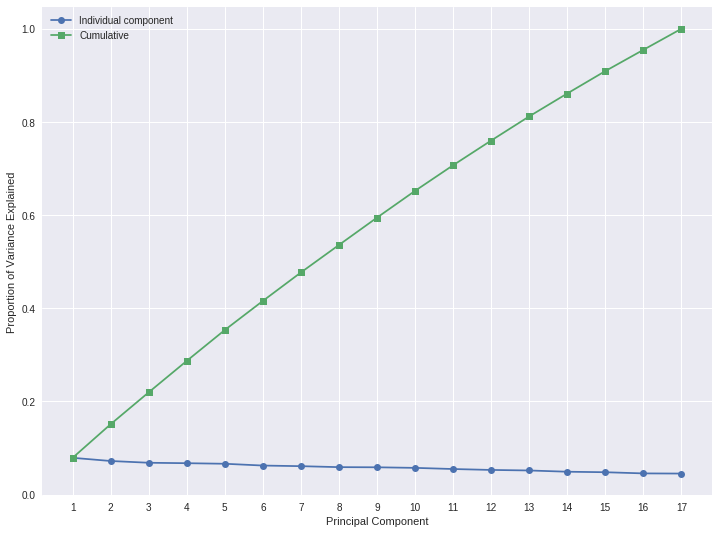

In [13]:
plt.figure(figsize=(12,9))

plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17], pca.explained_variance_ratio_, '-o', label='Individual component')
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17], np.cumsum(pca.explained_variance_ratio_), '-s', label='Cumulative')

plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
#plt.xlim(0.75,4.25)
#plt.ylim(0,1.05)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])
plt.legend(loc=2);
plt.show()

### Task 5
##### 10 points

Select the number of components that accumulatively explain at least 90% of variance. Use them to morph the data, train a new model on the train data set, and test it on the test part of the data set.

<b><i>Based on the graph in Task 4, the first 14-15 components explain 90% of variances. I am choosing to work with 14.</i></b>

In [14]:
lidar_t5 = lidar_gaus.iloc[:][[1,2,3,4,5,6,7,8,9,10,11,12,13,14]]
lidar_t5.head(4)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,100.656,121.88,136.314,149.937,158.342,259.533,457.145,840.647,651.421,674.531,813.85,1028.48,1435.61,1285.34
1,114.487,134.277,143.239,147.592,182.761,242.354,511.464,721.679,881.809,760.384,1132.73,1030.88,1206.45,1297.53
2,118.528,113.962,121.727,147.076,217.47,239.76,564.284,762.94,650.625,844.742,1070.92,947.213,1244.45,1530.95
3,106.611,131.576,123.49,153.612,210.092,226.878,531.513,693.496,980.068,892.057,986.703,1229.93,1158.26,1308.53


In [15]:
lidar_gaus_train, lidar_gaus_test = sklearn.model_selection.train_test_split(lidar_t5,train_size = 0.5)

pca.fit(lidar_gaus_train)
pca.score(lidar_gaus_test)

-72.580269752646416